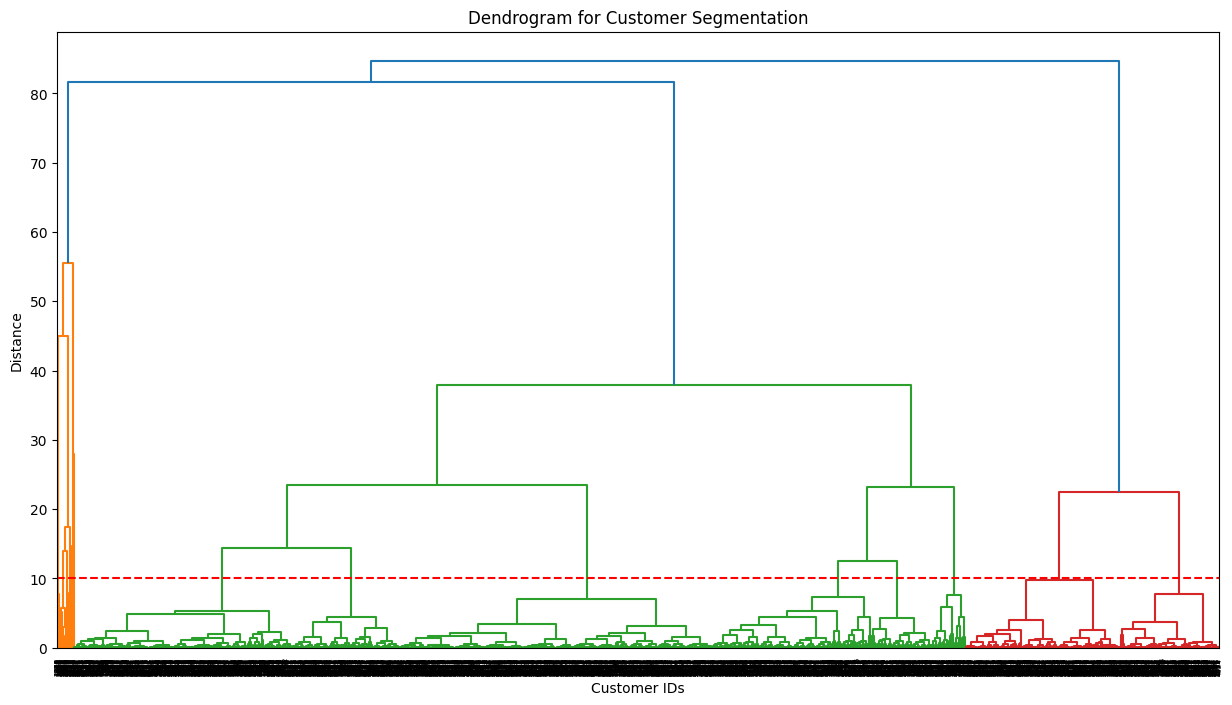

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         325          1  77183.60        2
12347.0           1          7   4310.00       10
12348.0          74          4   1797.24       11
12349.0          18          1   1757.55        8
12350.0         309          1    334.40        1


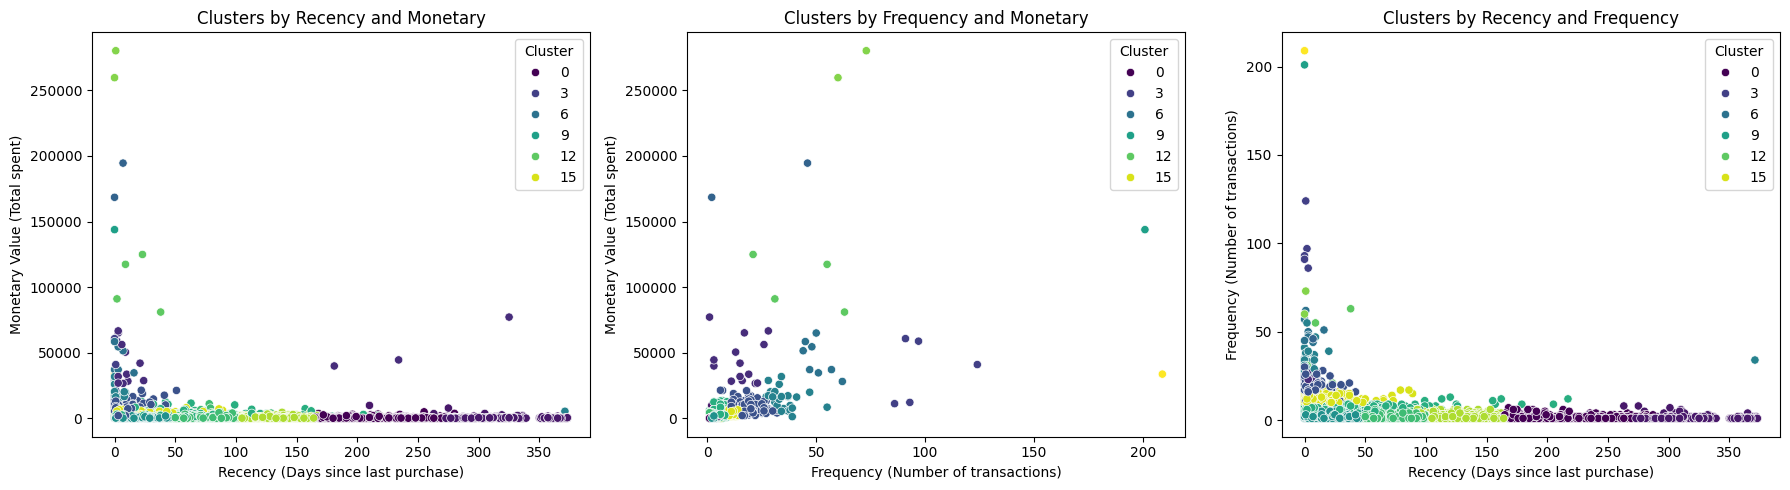

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Data_set/ML project/OnlineRetail.csv', encoding='ISO-8859-1')

# Data Preprocessing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Feature Engineering: Create RFM table
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
NOW = df['InvoiceDate'].max()

rfmTable = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Rename columns
rfmTable.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'Monetary'}, inplace=True)
rfmTable['Recency'] = rfmTable['Recency'].astype(int)

# Feature Scaling
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfmTable)
scaled_rfm = pd.DataFrame(scaled_rfm, index=rfmTable.index, columns=rfmTable.columns)

# Perform Hierarchical Clustering
linkage_matrix = linkage(scaled_rfm, method='ward')

# Plot Dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Customer Segmentation')
plt.xlabel('Customer IDs')
plt.ylabel('Distance')
plt.axhline(y=10, color='r', linestyle='--')  # Threshold for cluster separation
plt.show()

# Automatically determine the number of clusters using fcluster (elbow method)
max_d = 10  # Adjust based on dendrogram observation
y_pred = fcluster(linkage_matrix, max_d, criterion='distance')

# Apply Agglomerative Clustering
n_clusters = len(set(y_pred))  # Auto-detect cluster count
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = cluster_model.fit_predict(scaled_rfm)

# Add cluster labels to RFM table
rfmTable['Cluster'] = cluster_labels

# Display the first few rows of the clustered data
print(rfmTable.head())

# Visualizing Clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency vs Monetary
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfmTable, palette='viridis', ax=axes[0])
axes[0].set_title('Clusters by Recency and Monetary')
axes[0].set_xlabel('Recency (Days since last purchase)')
axes[0].set_ylabel('Monetary Value (Total spent)')

# Frequency vs Monetary
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfmTable, palette='viridis', ax=axes[1])
axes[1].set_title('Clusters by Frequency and Monetary')
axes[1].set_xlabel('Frequency (Number of transactions)')
axes[1].set_ylabel('Monetary Value (Total spent)')

# Recency vs Frequency
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfmTable, palette='viridis', ax=axes[2])
axes[2].set_title('Clusters by Recency and Frequency')
axes[2].set_xlabel('Recency (Days since last purchase)')
axes[2].set_ylabel('Frequency (Number of transactions)')

plt.tight_layout()
plt.show()
